##FeatureEngineering 유의사항
###1. row clean
각자 Feature들 보시면서 우선적으로 NA 값이나 이상치부터 확인해주세요. 이 것들을 1) Impute or 2) 삭제하도록 하겠습니다.
(이 과정을 생략하게 되면 모델 돌릴 때 NA 값 때문에 모델이 돌아가지 않습니다)
Train 데이터프레임을 받아서 행만 삭제한 새로운 데이터프레임 형태로 다음 분이 그대로 이어서 행 삭제할 수 있도록 함수화해주시면 되겠습니다.
 </br> </br>
def row_clean(OLD_TRAIN_SET) :

.....

return NEW_TRAIN_SET
 </br>

###2. FeatureEngineering
모형에 들어갈 수 있고 변수가 의미를 가지도록 변수를 만질 수 있도록 해 주세요.
이 과정도 함수화, Pipeline화해서 나중에 Tunning하기 좋게 하면 좋을 거 같아요.
FeatureEngineering해서 numpy형식으로 출력되도록 하는 게 좋을 것 같아요.
 </br> 
 </br>
### FeatureEngineering on
gas var : 'gas_engry_us_201401' ~ </br>
ele_var : 'ele_engry_us_201812' ~  </br>
lw_var : 'lw' ~ 

## 0. Setting

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir("/content/drive/My Drive/gimhae")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['PJT002_validation.csv', 'PJT002_test.csv', 'PJT002_train.csv']

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer                           
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.experimental import enable_iterative_imputer # 이거머지.
from sklearn.impute import IterativeImputer #모르겠다
from sklearn.decomposition import PCA

In [0]:
wd = "/content/drive/My Drive/gimhae/"
train_set = pd.read_csv((wd+'PJT002_train.csv'),encoding='utf-8' )
validation_set = pd.read_csv((wd+'PJT002_validation.csv'),encoding='utf-8' )
# 일단 무거우니까 test_set 놔 둠.
# test_set = pd.read_csv(('PJT002_test.csv')

train_set.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(59199, 180)

## 0-1. 변수 조정

어제 본 대로 lw열은 그대로 사용해도 무방할 것 같지만, gas열과 ele열은 변형이 필요했습니다. 화재가 난 날짜 기준 '전 6개월 사용량의 합'으...로 하려다가 이러면 계절의 영향을 심하게 받으니 전체 평균과의 차로 변수를 생성해보도록 하겠습니다. 

In [0]:
train_set.head()

,dt_of_fr,fr_yn,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,ttl_dwn_flr,bldng_us_clssfctn,tmprtr,prcpttn,wnd_spd,wnd_drctn,hmdt,gas_engry_us_201401,ele_engry_us_201401,gas_engry_us_201402,ele_engry_us_201402,gas_engry_us_201403,ele_engry_us_201403,gas_engry_us_201404,ele_engry_us_201404,gas_engry_us_201405,ele_engry_us_201405,gas_engry_us_201406,ele_engry_us_201406,gas_engry_us_201407,ele_engry_us_201407,gas_engry_us_201408,ele_engry_us_201408,gas_engry_us_201409,ele_engry_us_201409,gas_engry_us_201410,ele_engry_us_201410,gas_engry_us_201411,ele_engry_us_201411,gas_engry_us_201412,...,lw_13101211,lw_13101310,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,jmk,id,rgnl_ar_nm,rgnl_ar_nm2,lnd_us_sttn_nm,rd_sd_nm,emd_nm,hm_cnt,fr_sttn_dstnc,bldng_ar_prc,fr_wthr_fclt_dstnc,fr_mn_cnt,mlt_us_yn,cctv_dstnc,fr_wthr_fclt_in_100m,cctv_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn
0,2017-10-20 05:54:00,Y,단독주택,블록구조,3,69.42,69.42,0.0,1977,1.0,0.0,주거용,10.7,NaN,0.9,200.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,106536,자연녹지지역,지정되지않음,단독,세로한면(불),경상남도 창녕군 창녕읍,17360.0,4547,NaN,133,137.0,N,112,0,0,1891,29231,11322,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-30 08:26:15,N,NaN,NaN,3,46.29,46.29,0.0,NaN,1.0,0.0,NaN,19.5,NaN,0.5,20.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,86366,계획관리지역,지정되지않음,단독,세로한면(가),경상남도 의령군 가례면,1791.0,6388,122581.0,489,85.0,N,818,0,0,4533,20480,3369,7727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-10-30 14:57:00,Y,공동주택,철근콘크리트구조,1,583.80,2516.76,1446.0,2.00011e+07,5.0,0.0,주거용,15.5,NaN,2.0,90.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,답,107560,제2종일반주거지역,지정되지않음,연립,중로한면,경상남도 창녕군 창녕읍,17285.0,3340,618105.0,143,137.0,N,165,0,0,277,31197,12451,72,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-06-14 05:23:58,N,단독주택,일반목구조,2,48.92,48.92,0.0,1936,1.0,0.0,주거용,20.6,NaN,0.4,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,97550,제1종일반주거지역,지정되지않음,단독,세로한면(불),경상남도 창원시의창구 대산면,7327.0,179,719542.0,1585,176.0,N,131,0,0,438,4270,407,508,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-22 05:38:59,N,NaN,NaN,2,0.00,0.00,0.0,NaN,NaN,NaN,NaN,12.7,NaN,0.6,360.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,임,130501,자연환경보전지역,지정되지않음,자연림,세로한면(불),경상남도 창녕군 창녕읍,17278.0,4822,NaN,603,137.0,N,686,0,0,1702,29778,12487,707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#train_engry_mean = train_set.loc[:,'gas_engry_us_201401':'ele_engry_us_201812'].groupby()#.describe().loc["mean",:]
#pd.Series(train_engry_mean.keys()).str.split('_', expand = True).iloc[:,3]
#np.where(train_rst['fr_month'][2] == 
#train_engry_mean[np.where(train_rst['fr_month'][2] == pd.Series(train_engry_mean.keys()).str.split('_', expand = True).iloc[:,3])[0]]
train_engry_mean_df = pd.DataFrame(train_engry_mean.items())
train_engry_mean_df.loc[:,2] = pd.DataFrame(train_engry_mean.items()).loc[:,0].str.split('_', expand = True).iloc[:,3]
train_engry_mean_df.loc[:,0] = pd.DataFrame(train_engry_mean.items()).loc[:,0].str.split('_', expand = True).iloc[:,0]

train_engry_wide = train_engry_mean_df.pivot(index = 2, columns = 0, values = 1)
train_engry_wide
#train_engry_mean_df

여기는 안봐도 됩니다. 처음에는 계절의 영향을 줄이기 위해서 해당 월의 평균을 빼보려고 했어요. 지우기 아까워서 그냥 둔거임 ㅇㅇ

In [0]:
sc = StandardScaler()

train_rst = train_set.assign(
    fr_month_gas  = 'gas'+train_set['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False) #불이 난 달 + gas로 차후 index로 기능할 열을 생성합니다.
).assign(
    fr_month_ele  = 'ele'+train_set['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False) #마찬가지 ele에 대해서
)
train_rst.loc[:,'gas_engry_us_201401':'ele_engry_us_201812'] = sc.fit_transform(train_rst.loc[:,'gas_engry_us_201401':'ele_engry_us_201812']) #표준화입니다.

In [0]:
tk = train_rst.keys()[np.where(pd.Series(train_rst.keys()) == 'gas_engry_us_201401')[0][0]:np.where(pd.Series(train_rst.keys()) == 'ele_engry_us_201812')[0][0]+1]
keys = pd.Series(tk).str.split('_', expand = True).iloc[:,[0,3]]
keys[1] = keys[0]+keys[3]
keys

,0,3,1
0,gas,201401,gas201401
1,ele,201401,ele201401
2,gas,201402,gas201402
3,ele,201402,ele201402
4,gas,201403,gas201403
...,...,...,...
115,ele,201810,ele201810
116,gas,201811,gas201811
117,ele,201811,ele201811
118,gas,201812,gas201812


In [0]:
#train_rst.head()
coln = train_rst.iloc[:,:17].columns.values.tolist() + keys[1].ravel().tolist() + train_rst.iloc[:,137:].columns.values.tolist() #열 이름을 바꿔줄 준비. 앞선 fr_month_gas/ ele열을 index로 사용하기 위함입니다
len(coln)
train_rst.columns = coln #열 이름 변경
train_rst.head()

,dt_of_fr,fr_yn,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,ttl_dwn_flr,bldng_us_clssfctn,tmprtr,prcpttn,wnd_spd,wnd_drctn,hmdt,gas201401,ele201401,gas201402,ele201402,gas201403,ele201403,gas201404,ele201404,gas201405,ele201405,gas201406,ele201406,gas201407,ele201407,gas201408,ele201408,gas201409,ele201409,gas201410,ele201410,gas201411,ele201411,gas201412,...,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,jmk,id,rgnl_ar_nm,rgnl_ar_nm2,lnd_us_sttn_nm,rd_sd_nm,emd_nm,hm_cnt,fr_sttn_dstnc,bldng_ar_prc,fr_wthr_fclt_dstnc,fr_mn_cnt,mlt_us_yn,cctv_dstnc,fr_wthr_fclt_in_100m,cctv_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn,fr_month_gas,fr_month_ele
0,2017-10-20 05:54:00,Y,단독주택,블록구조,3,69.42,69.42,0.0,1977,1.0,0.0,주거용,10.7,NaN,0.9,200.0,96.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,106536,자연녹지지역,지정되지않음,단독,세로한면(불),경상남도 창녕군 창녕읍,17360.0,4547,NaN,133,137.0,N,112,0,0,1891,29231,11322,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201710,ele201710
1,2018-09-30 08:26:15,N,NaN,NaN,3,46.29,46.29,0.0,NaN,1.0,0.0,NaN,19.5,NaN,0.5,20.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,86366,계획관리지역,지정되지않음,단독,세로한면(가),경상남도 의령군 가례면,1791.0,6388,122581.0,489,85.0,N,818,0,0,4533,20480,3369,7727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201809,ele201809
2,2016-10-30 14:57:00,Y,공동주택,철근콘크리트구조,1,583.80,2516.76,1446.0,2.00011e+07,5.0,0.0,주거용,15.5,NaN,2.0,90.0,21.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,답,107560,제2종일반주거지역,지정되지않음,연립,중로한면,경상남도 창녕군 창녕읍,17285.0,3340,618105.0,143,137.0,N,165,0,0,277,31197,12451,72,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201610,ele201610
3,2016-06-14 05:23:58,N,단독주택,일반목구조,2,48.92,48.92,0.0,1936,1.0,0.0,주거용,20.6,NaN,0.4,0.0,91.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,97550,제1종일반주거지역,지정되지않음,단독,세로한면(불),경상남도 창원시의창구 대산면,7327.0,179,719542.0,1585,176.0,N,131,0,0,438,4270,407,508,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201606,ele201606
4,2018-04-22 05:38:59,N,NaN,NaN,2,0.00,0.00,0.0,NaN,NaN,NaN,NaN,12.7,NaN,0.6,360.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,임,130501,자연환경보전지역,지정되지않음,자연림,세로한면(불),경상남도 창녕군 창녕읍,17278.0,4822,NaN,603,137.0,N,686,0,0,1702,29778,12487,707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201804,ele201804


In [0]:
# 합 코드. 전 6월이 없어서 잘 안돌아갑니다.
train_rst.assign(
    gas_6m = np.sum(train_rst.iloc[:,np.arange(np.where(train_rst.loc[0,'fr_month_gas'] == train_rst.keys())[0][0]-5 , np.where(train_rst.loc[0,'fr_month_gas'] == train_rst.keys())[0][0]+1)])
)

,dt_of_fr,fr_yn,bldng_us,bldng_archtctr,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,dt_of_athrztn,ttl_grnd_flr,ttl_dwn_flr,bldng_us_clssfctn,tmprtr,prcpttn,wnd_spd,wnd_drctn,hmdt,gas201401,ele201401,gas201402,ele201402,gas201403,ele201403,gas201404,ele201404,gas201405,ele201405,gas201406,ele201406,gas201407,ele201407,gas201408,ele201408,gas201409,ele201409,gas201410,ele201410,gas201411,ele201411,gas201412,...,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011,jmk,id,rgnl_ar_nm,rgnl_ar_nm2,lnd_us_sttn_nm,rd_sd_nm,emd_nm,hm_cnt,fr_sttn_dstnc,bldng_ar_prc,fr_wthr_fclt_dstnc,fr_mn_cnt,mlt_us_yn,cctv_dstnc,fr_wthr_fclt_in_100m,cctv_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,trgt_crtr,fr_fghtng_fclt_spcl_css_5_yn,fr_fghtng_fclt_spcl_css_6_yn,us_yn,dngrs_thng_yn,slf_fr_brgd_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn,fr_month_gas,fr_month_ele,gas_6m
0,2017-10-20 05:54:00,Y,단독주택,블록구조,3,69.420,69.4200,0.0,1977,1.0,0.0,주거용,10.7,NaN,0.9,200.0,96.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,106536,자연녹지지역,지정되지않음,단독,세로한면(불),경상남도 창녕군 창녕읍,17360.0,4547,NaN,133,137.0,N,112,0,0,1891,29231,11322,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201710,ele201710,NaN
1,2018-09-30 08:26:15,N,NaN,NaN,3,46.290,46.2900,0.0,NaN,1.0,0.0,NaN,19.5,NaN,0.5,20.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,86366,계획관리지역,지정되지않음,단독,세로한면(가),경상남도 의령군 가례면,1791.0,6388,122581.0,489,85.0,N,818,0,0,4533,20480,3369,7727,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201809,ele201809,NaN
2,2016-10-30 14:57:00,Y,공동주택,철근콘크리트구조,1,583.800,2516.7600,1446.0,2.00011e+07,5.0,0.0,주거용,15.5,NaN,2.0,90.0,21.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,답,107560,제2종일반주거지역,지정되지않음,연립,중로한면,경상남도 창녕군 창녕읍,17285.0,3340,618105.0,143,137.0,N,165,0,0,277,31197,12451,72,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201610,ele201610,NaN
3,2016-06-14 05:23:58,N,단독주택,일반목구조,2,48.920,48.9200,0.0,1936,1.0,0.0,주거용,20.6,NaN,0.4,0.0,91.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,대,97550,제1종일반주거지역,지정되지않음,단독,세로한면(불),경상남도 창원시의창구 대산면,7327.0,179,719542.0,1585,176.0,N,131,0,0,438,4270,407,508,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201606,ele201606,NaN
4,2018-04-22 05:38:59,N,NaN,NaN,2,0.000,0.0000,0.0,NaN,NaN,NaN,NaN,12.7,NaN,0.6,360.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,임,130501,자연환경보전지역,지정되지않음,자연림,세로한면(불),경상남도 창녕군 창녕읍,17278.0,4822,NaN,603,137.0,N,686,0,0,1702,29778,12487,707,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas201804,ele201804,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59194,2016-12-03 14:25:35,N,동.식물 관련시설,경량철골구조,2,423.000,423.0000,3010.0,1.99612e+07,NaN,NaN,NaN,11.2,NaN,0.2,0.0,41.0,-0.010086,-0.01238,-0.010589,-0.01243,-0.010532,-0.011999,-0.010706,-0.01081,-0.010256,-0.010711,-0.011803,-0.010643,-0.006933,-0.01066,-0.015358,-0.011203,-0.013812,-0.013064,-0.011446,-0.017005,-0.019119,-0.023046,-0.025035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,목

In [0]:
# 해당 달만 쓰는 코드.
train_eg = train_rst.assign(
    gas_fm = train_rst.iloc[:,np.where(train_rst.loc[0,'fr_month_gas'] == train_rst.keys())[0][0]]
).assign(
    ele_fm = train_rst.iloc[:,np.where(train_rst.loc[0,'fr_month_ele'] == train_rst.keys())[0][0]]
).drop(['fr_month_gas','fr_month_ele'], axis = 1)
# 여러가지 방법이 있겠지만, gas_fm, ele_fm열만 따로 빼서 데이터로 저장한 뒤에 붙이는 식으로 하는게 제일 좋아보이니 일단 저장합니다.  

In [0]:
train_eg.loc[:,['gas_fm', 'ele_fm']].to_csv('preprocessing_ele,gas.csv')
train_eg.to_csv('train_eg.csv')

## 1. DB Cleaning

In [0]:
gas = train_eg.loc[:,'gas_fm']
ele = train_eg.loc[:,'ele_fm']
lw = train_eg.loc[:,'lw_13101010':'lw_13141011']

In [0]:
print(sum(gas.isna())) #대충 반절정도 살아남네요
print(sum(ele.isna())) #gas가 없으면 ele도 없습니다. Q&A를 확인한 결과 실수로 누락된 정보는 없다고 하니 이처럼 둘의 결측의 개수가 같은 것이 맞습니다. 

27581
27581


어제 lw변수에는 outlier가 없는 것을 확인했으니, gas와 ele쪽만 보도록 하겠습니다. 

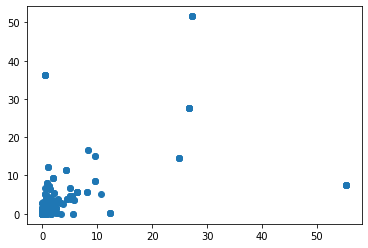

In [0]:
plt.scatter(gas, ele)

대충 다섯개 정도 크게 퍼져있는 값이 보입니다. 

In [0]:
print('gas 쪽에서 outlier들')
print(gas[gas>20]) 
print('')
print('ele 쪽에서 outlier들')
print(ele[ele>30]) # 똑같은 값이 겹쳐있는 거네요. 이게 다른 건물이라는게 말이 안되지만, 또 몇몇 값은 실제로 다르니 그냥 그렇다고 합시다. 아무튼 이정도의 관측값들을 이상치라 볼 수 있을겁니다.

gas 쪽에서 outlier들
2692     24.825743
2694     24.825743
2704     24.825743
2714     24.825743
12637    27.341537
12645    27.341537
12658    27.341537
12664    27.341537
12786    27.341537
30341    26.777732
33079    26.777732
36377    26.777732
36378    26.777732
36380    26.777732
36381    26.777732
56615    55.364131
56616    55.364131
56619    55.364131
56622    55.364131
56624    55.364131
56626    55.364131
Name: gas_fm, dtype: float64

ele 쪽에서 outlier들
3222     36.124720
12637    51.598312
12645    51.598312
12658    51.598312
12664    51.598312
12786    51.598312
49539    36.124720
49540    36.124720
49549    36.124720
49550    36.124720
49559    36.124720
Name: ele_fm, dtype: float64


말씀하신 대로 버릴 row를 찾고 나서 마저 합시다

## 2. Feature Engineering

In [0]:
egl_var = ['gas_fm', 'ele_fm','lw_13101010','lw_13101110','lw_13101210','lw_13101211','lw_13101310','lw_13101410','lw_13111010','lw_13111110','lw_13121010',
           'lw_13121011','lw_13131010','lw_13131110','lw_13141010','lw_13141011'] #관심변수들

In [0]:
train_eg[egl_var].head()

,gas_fm,ele_fm,lw_13101010,lw_13101110,lw_13101210,lw_13101211,lw_13101310,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011
0,-0.04007,-0.047839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.04007,-0.047839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.04007,-0.047839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


가스와 전기는 이미 사전에 표준화를 진행한 데이터라 따로 표준화를 진행할 필요가 없습니다. 서로 다른 파이프라인에 들어갑니다. 

In [0]:
eg_var = ['gas_fm', 'ele_fm']
lw_var = ['lw_13101010','lw_13101110','lw_13101210','lw_13101211','lw_13101310','lw_13101410','lw_13111010','lw_13111110','lw_13121010',
           'lw_13121011','lw_13131010','lw_13131110','lw_13141010','lw_13141011']

imputing을 해야 하는데, gas와 ele변수가 NaN인 경우는 에너지 관리 대상이 아닌 경우라 하니, 이 경우는 0으로 imputing하겠습니다. </br>
</br>
저 Outlier들은...일단은 그냥 둘게요 </br>


In [0]:
train_eg[lw_var].isna().sum()

lw_13101010    58897
lw_13101110    58908
lw_13101210    58902
lw_13101211    58901
lw_13101310    58907
lw_13101410    58916
lw_13111010    58899
lw_13111110    58918
lw_13121010    58926
lw_13121011    58926
lw_13131010    58903
lw_13131110    58903
lw_13141010    58907
lw_13141011    58908
dtype: int64

여기가...문젠데, lw_변수들은 20년 이상 된 노후건물 + (다중이용시설 / 연면적 합계 3천 이상인 건축물 / 다중이용업소)의 조건을 만족해야지만 측정이 되는 경우인지라 대부분의 행이 없습니다. </br>
</br>
맘같아선 그냥 최빈값 때려버리고 싶은데, 애초에 20년 이상된 노후건물 대상으로 조사한 열이니 그럴 수는 없고...그렇다고 외부 데이터도 없고...

In [0]:
#corr_with_d = lambda x: x.corrwith(x['d'])
t_vars = train_eg.keys().tolist()
t_vars[137:151] = []
t_vars # lw뺀 변수들입니다.

gas201407              -0.168922
bldng_cnt_in_50m       -0.160653
sft_emrgnc_bll_dstnc   -0.144450
no_tbc_zn_dstnc        -0.097747
fr_wthr_fclt_in_100m   -0.095728
                          ...   
ele201701               0.123352
tmprtr                  0.145238
prcpttn                 0.149495
ahsm_dstnc              0.178227
fr_mn_cnt               0.218705
Length: 147, dtype: float64

In [0]:
train_eg[t_vars].corrwith(train_eg[lw_var].iloc[:,1]).sort_values()

for i in range(len(lw_var)):
  print(train_eg[t_vars].corrwith(train_eg[lw_var].iloc[:,1]).abs().argmax())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  after removing the cwd from sys.path.


fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt
fr_mn_cnt


그래서 각각의 상관관계가 가장 높은 변수를 찾고, 그 변수의 값에 따라서 lw를 정하려고 했습니다. </br></br>

모든 lw변수는 fr_mn_cnt와 가장 높은 상관관계를 가졌는데, 이는 관할 소방서 인원입니다. 왜죠...?

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


41

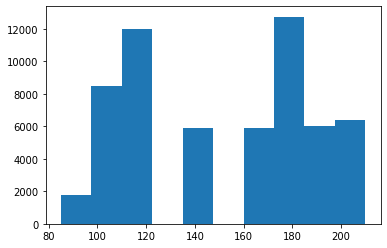

In [0]:
plt.hist(train_eg['fr_mn_cnt']) #일단 찍어봤습니다. 
train_eg['fr_mn_cnt'].isna().sum() # 결측이 거의 없네요.c

In [0]:
train_eg['fr_mn_cnt']
bins_cnt = np.linspace(85, 210, num = 10)
train_eg['fr_mn_cnt_cat'] = pd.cut(train_eg['fr_mn_cnt'], bins_cnt)
train_eg['fr_mn_cnt_cat'] #원래는 이렇게 categorize하려다가, 그냥 자체적으로 변수가 몇 개 없어서 그냥 씁니다. 지우기 귀찮아서 일단 둡니다.

85.0
210.0


0        (126.667, 140.556]
1                       NaN
2        (126.667, 140.556]
3        (168.333, 182.222]
4        (126.667, 140.556]
                ...        
59194    (126.667, 140.556]
59195    (126.667, 140.556]
59196    (126.667, 140.556]
59197    (126.667, 140.556]
59198    (126.667, 140.556]
Name: fr_mn_cnt_cat, Length: 59199, dtype: category
Categories (9, interval[float64]): [(85.0, 98.889] < (98.889, 112.778] < (112.778, 126.667] <
                                    (126.667, 140.556] ... (154.444, 168.333] < (168.333, 182.222] <
                                    (182.222, 196.111] < (196.111, 210.0]]

In [0]:
class lwimputer(BaseEstimator, TransformerMixin):
  def __init__(self, value = True):
    self.value = value
  def fit(self, X,y = None):
    return(self)
  def transform(self, X, y = None):
    cat_mean = X[lw_var+['fr_mn_cnt'].groupby('fr_mn_cnt').mean()
    return cat_mean

SyntaxError: ignored

만들어보려다가 빡쳐서 때리쳤습니다. 

In [0]:
fr_mn_lw = train_eg[lw_var+['fr_mn_cnt']].groupby('fr_mn_cnt').mean()
fr_mn_lw

,lw_13101010,lw_13101110,lw_13101210,lw_13101211,lw_13101310,lw_13101410,lw_13111010,lw_13111110,lw_13121010,lw_13121011,lw_13131010,lw_13131110,lw_13141010,lw_13141011
fr_mn_cnt,,,,,,,,,,,,,,
85.0,3.541667,4.000000,3.000000,3.541667,3.000000,0.000000,4.000000,3.058824,0.000000,0.000000,0.000000,0.000000,3.000000,3.541667
106.0,3.740000,2.809524,4.000000,3.740000,3.740000,0.000000,3.740000,3.500000,1.142857,1.142857,3.740000,3.740000,3.500000,4.000000
108.0,2.666667,2.333333,3.000000,3.666667,3.000000,2.333333,4.000000,1.333333,0.000000,0.000000,2.666667,2.666667,3.666667,3.666667
109.0,3.307312,1.158772,3.500000,3.583333,3.469697,3.003216,3.916667,0.000000,0.000000,0.000000,2.335726,2.335726,1.655797,1.395833
111.0,4.000000,3.000000,3.500000,4.000000,4.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,3.000000,4.000000,2.000000
112.0,3.735537,2.277512,3.839713,3.772727,3.636364,1.127273,3.500000,1.313876,0.000000,0.000000,2.454545,2.454545,2.392562,2.590909
118.0,3.600000,4.000000,3.600000,3.600000,2.666667,1.333333,4.000000,0.000000,0.000000,0.000000,3.000000,3.000000,2.333333,1.666667
121.0,3.000000,3.000000,2.500000,2.500000,3.500000,0.900000,3.500000,0.000000,0.900000,0.900000,3.500000,3.500000,3.000000,3.000000
137.0,3.775556,3.720000,3.944444,3.888889,4.000000,2.221534,4.000000,1.192982,0.666667,0.666667,3.780185,3.780185,2.304094,2.228070


In [0]:
#SI = SimpleImputer(strategy='most_frequent')
#SI.fit_transform(train_set['fr_mn_cnt'],1)
#train_set['fr_mn_cnt'].isna().sum()
from collections import Counter as cc
cnt = cc(train_eg['fr_mn_cnt']) 
train_eg['fr_mn_cnt'][train_eg['fr_mn_cnt'].isna()] = cnt.most_common()[0][0] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


일단 fr_mn_cnt변수가 결측이 거의 없어서 41개의 결측을 최빈값으로 대채합니다. 

In [0]:
from tqdm import tqdm

for i in tqdm(range(len(train_eg))):
  for j in lw_var:
      if np.isnan(train_eg.loc[i,j]):
            train_eg.loc[i,j] = fr_mn_lw.loc[train_eg['fr_mn_cnt'][i],j] #이후 fr_mn_cnt를 기준으로 lw를 대체합니다. 이걸...imputer로 어떻게 만들까요.

100%|██████████| 59199/59199 [08:34<00:00, 114.96it/s]


In [0]:
train_eg.to_csv('train_eg.csv')

In [0]:
eg_imputer = Pipeline([
                       ('zero_imputer', SimpleImputer(strategy='constant',fill_value=0))
])

lw_scaler = Pipeline([
                      ('scaler', StandardScaler())
])

egl_pipe = ColumnTransformer([
                     ('eg_imputer', eg_imputer, eg_var),
                     ('lw_scaler', lw_scaler, lw_var)
                     ])

In [0]:
egl_pipe.fit_transform(train_eg[egl_var])

array([[-0.0400703 , -0.04783937,  0.98559526, ...,  1.27295858,
        -0.65121364, -0.5742121 ],
       [ 0.        ,  0.        ,  0.36816641, ..., -4.30943139,
         0.50424206,  1.2423093 ],
       [-0.0400703 , -0.04783937,  0.98559526, ...,  1.27295858,
        -0.65121364, -0.5742121 ],
       ...,
       [ 0.        ,  0.        , -1.04956215, ...,  0.09335743,
        -1.96586346, -2.19166314],
       [-0.0400703 , -0.04779988, -1.04956215, ...,  0.09335743,
        -1.96586346, -2.19166314],
       [-0.0400703 , -0.04781099,  0.98559526, ...,  1.27295858,
        -0.65121364, -0.5742121 ]])

In [0]:
egl_pipe.get_params()

{'eg_imputer': Pipeline(memory=None,
          steps=[('zero_imputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=0,
                                missing_values=nan, strategy='constant',
                                verbose=0))],
          verbose=False),
 'eg_imputer__memory': None,
 'eg_imputer__steps': [('zero_imputer',
   SimpleImputer(add_indicator=False, copy=True, fill_value=0, missing_values=nan,
                 strategy='constant', verbose=0))],
 'eg_imputer__verbose': False,
 'eg_imputer__zero_imputer': SimpleImputer(add_indicator=False, copy=True, fill_value=0, missing_values=nan,
               strategy='constant', verbose=0),
 'eg_imputer__zero_imputer__add_indicator': False,
 'eg_imputer__zero_imputer__copy': True,
 'eg_imputer__zero_imputer__fill_value': 0,
 'eg_imputer__zero_imputer__missing_values': nan,
 'eg_imputer__zero_imputer__strategy': 'constant',
 'eg_imputer__zero_imputer__verbose': 0,
 'lw_scaler': Pipeline(memory=None,
